# Imports

In [ ]:
# Se cambia al directorio donde esté el notebook con las clases a importar
%cd "/content/drive/MyDrive/Colab_Notebooks/SRGAN"

!pip install -q torchmetrics    # Paquete de métricas

# Manejo y representación de datos
import os 
import matplotlib.pyplot as plt
from tqdm import tqdm

# Pytorch 
import torch

# Dataset y Dataloader
from torch.utils.data import DataLoader

# Modelos y clases
from dataset import *
from train import *
from config import *



/content/drive/MyDrive/Colab_Notebooks/SRGAN
     |████████████████████████████████| 282 kB 13.0 MB/s 


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

GENERATOR VALIDATION:   0%|          | 0/25 [00:01<?, ?batch/s, PSNR=21.4, RMSE=0.0853, SSIM=0.736]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
ADVERSARIAL TRAIN - EPOCH: [1/2]:   0%|          | 0/100 [00:00<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
ADVERSARIAL VALIDATION: 100%|██████████| 25/25 [00:09<00:00,  2.

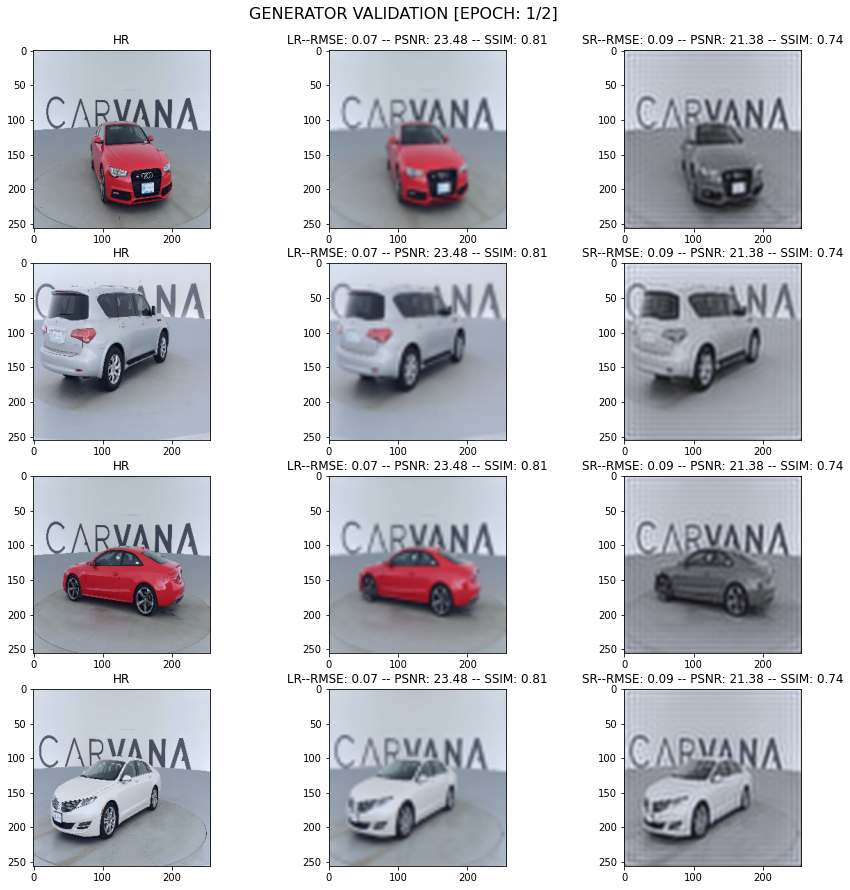

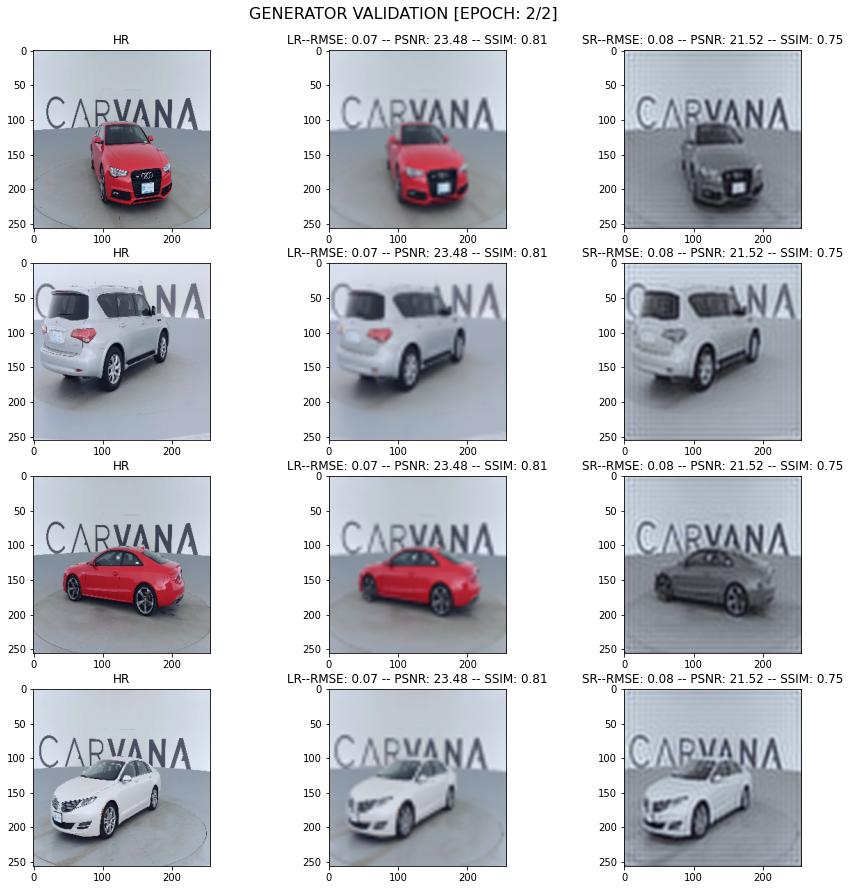

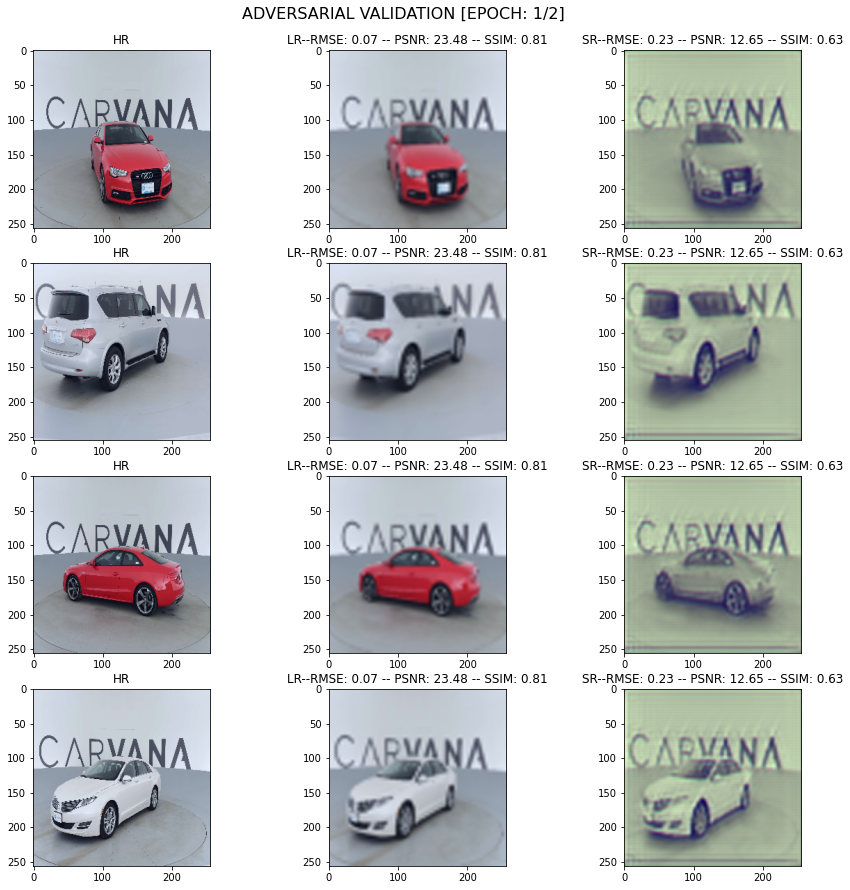

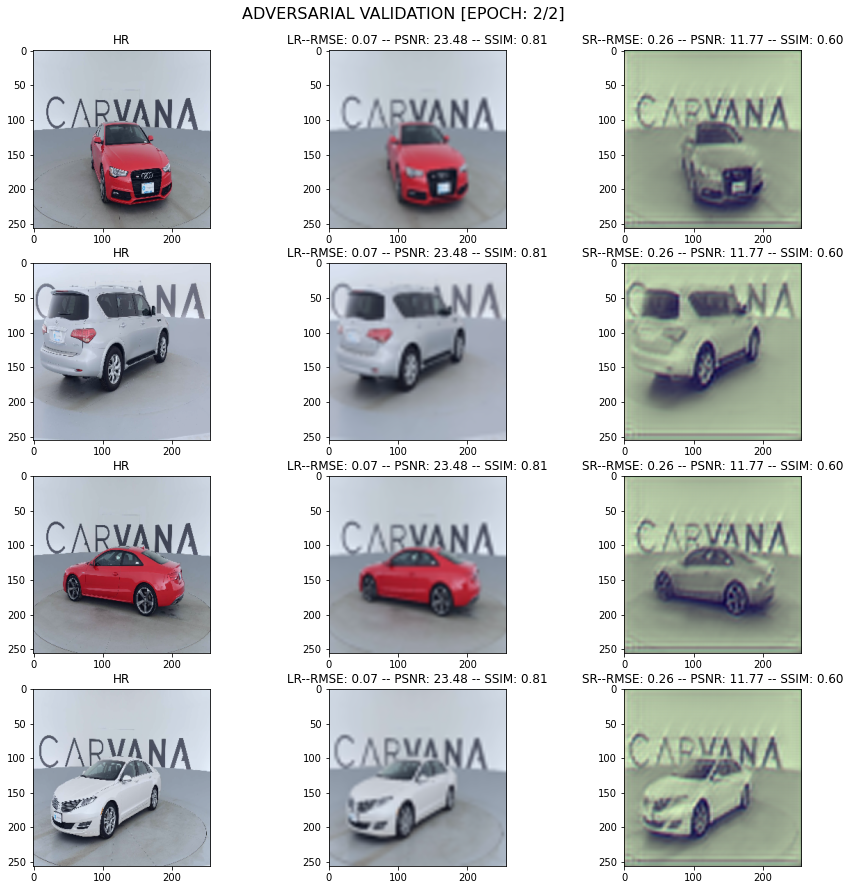

In [ ]:
# ------------------------------------------------------------------------------
# ------------ Datasets y dataloaders ------------------------------------------
# ------------------------------------------------------------------------------
# Datasets de entrenamiento y evaluación
carDatasetTrain = CarDataset(df=df_train, transforms=transforms)
carDatasetval   = CarDataset(df=df_val, transforms=transforms)

# Dataloaders de entrenamiento y evaluación
train_dataloader  = DataLoader(carDatasetTrain, batch_size=bs,
                                shuffle=True, num_workers=0)
val_dataloader    = DataLoader(carDatasetval, batch_size=bs,
                                shuffle=False, num_workers=0) # val_dataloader sin shuffle

# ------------------------------------------------------------------------------
# ------------ Entrenamiento y validación --------------------------------------
# ------------------------------------------------------------------------------

# Se inicializan listas vacias en las que se almacenarán lás metricas para cada epoch

tg_pixel_loss, tg_psnr, tg_ssim, tg_rmse = [], [], [], []          # Métricas entrenamiento generador
vg_psnr, vg_ssim, vg_rmse = [], [], []                             # Métricas validación generador

ta_gloss, ta_dloss, ta_psnr, ta_ssim, ta_rmse = [], [], [], [], [] # Métricas entrenamiento adversarial
va_psnr, va_ssim, va_rmse = [], [], []                             # Métricas validación adversarial

# Entrenamiento y validación del generador
if os.path.exists('/content/drive/MyDrive/Colab_Notebooks/SRGAN/saved_models/p-best.pth'):
    generator.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/SRGAN/saved_models/p-best.pth', map_location=torch.device(device))) # Se cargan los pesos del modelo

for epoch in range(p_epochs) :

    # Entrenamiento
    with tqdm(train_dataloader,unit='batch') as tloader : 
        tg_scores = train_generator(epoch, p_epochs, tloader, generator, pixel_criterion, optimizer_P,device)
        
        tg_pixel_loss.append(tg_scores[0])
        tg_psnr.append(tg_scores[1])
        tg_ssim.append(tg_scores[2])
        tg_rmse.append(tg_scores[3])

    # Validación
    with tqdm(val_dataloader,unit='batch') as vloader : 
        vg_scores = validate(epoch,p_epochs,vloader,"GENERATOR",generator,device,bs)

        vg_psnr.append(vg_scores[0])
        vg_ssim.append(vg_scores[1])
        vg_rmse.append(vg_scores[2])

        if epoch == 0:
            best_psnr_value = 0  
        is_best = vg_psnr[epoch] > best_psnr_value
        best_psnr_value = max(vg_psnr[epoch], best_psnr_value)
        if is_best:
            torch.save(generator.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/SRGAN/saved_models/p-best.pth")
    

# Entrenamiento y validación adversarial
generator.load_state_dict(torch.load("/content/drive/MyDrive/Colab_Notebooks/SRGAN/saved_models/p-best.pth", map_location=torch.device(device)))
if os.path.exists('/content/drive/MyDrive/Colab_Notebooks/SRGAN/saved_models/d-best.pth'):
    discriminator.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/SRGAN/saved_models/d-best.pth', map_location=torch.device(device))) # Se cargan los pesos del modelo

for epoch in range(epochs) :

    # Entrenamiento adversarial
    with tqdm(train_dataloader,unit='batch') as tloader : 

        ta_scores = train_adversarial(epoch, epochs, tloader, generator, optimizer_G, discriminator, optimizer_D, adversarial_criterion, pixel_criterion, content_criterion, device)

        # Se almacenan las métricas en las listas correspondientes
        ta_gloss.append(ta_scores[0])
        ta_dloss.append(ta_scores[1])
        ta_psnr.append(ta_scores[2])
        ta_ssim.append(ta_scores[3])
        ta_rmse.append(ta_scores[4])



    # Validación adversarial
    with tqdm(val_dataloader,unit='batch') as vloader : 
        va_scores = validate(epoch,epochs,vloader,"ADVERSARIAL",generator,device,bs)
        # Se almacenan las métricas en las listas correspondientes
        va_psnr.append(va_scores[0])
        va_ssim.append(va_scores[1])
        va_rmse.append(va_scores[2])

        if epoch == 0:
            best_psnr_value = 0  
        is_best = va_psnr[epoch] > best_psnr_value
        best_psnr_value = max(va_psnr[epoch], best_psnr_value)
        if is_best:
            torch.save(discriminator.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/SRGAN/saved_models/d-best.pth")
            torch.save(generator.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/SRGAN/saved_models/g-best.pth")
    scheduler_D.step()
    scheduler_G.step() 
     



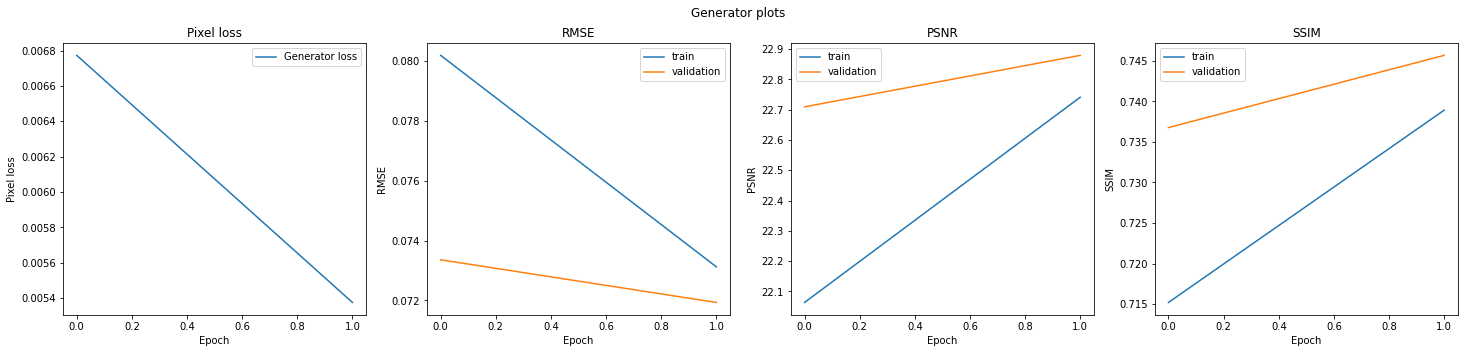

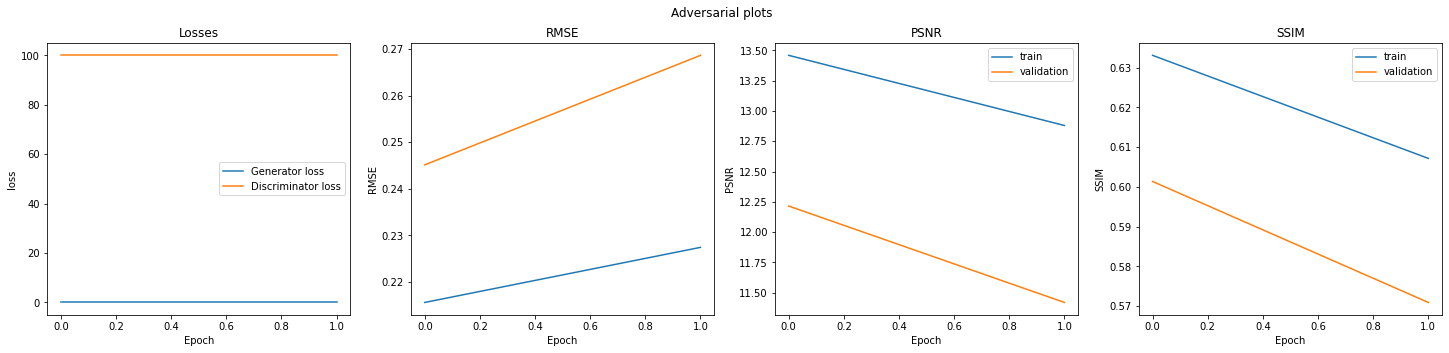

In [ ]:
# Generator plots
plt.figure(figsize=(25,5))
plt.suptitle("Generator plots")

plt.subplot(1,4,1)
plt.title(f"Pixel loss")
plt.xlabel('Epoch')
plt.ylabel('Pixel loss')
plt.plot(tg_pixel_loss, label='Generator loss')
plt.legend()

plt.subplot(1,4,2)
plt.title(f"RMSE")
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.plot(tg_rmse, label='train')
plt.plot(vg_rmse, label='validation')
plt.legend()

plt.subplot(1,4,3)
plt.title(f"PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.plot(tg_psnr, label='train')
plt.plot(vg_psnr, label='validation')
plt.legend()

plt.subplot(1,4,4)
plt.title(f"SSIM")
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.plot(tg_ssim, label='train')
plt.plot(vg_ssim, label='validation')
plt.legend()



# Adversarial plots
plt.figure(figsize=(25,5))
plt.suptitle("Adversarial plots")

plt.subplot(1,4,1)
plt.title(f"Losses")
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.plot(ta_gloss, label='Generator loss')
plt.plot(ta_dloss, label='Discriminator loss')
plt.legend()

plt.subplot(1,4,2)
plt.title(f"RMSE")
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.plot(ta_rmse, label='train')
plt.plot(va_rmse, label='validation')

plt.subplot(1,4,3)
plt.title(f"PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.plot(ta_psnr, label='train')
plt.plot(va_psnr, label='validation')
plt.legend()

plt.subplot(1,4,4)
plt.title(f"SSIM")
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.plot(ta_ssim, label='train')
plt.plot(va_ssim, label='validation')
plt.legend()
